In [3]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import seaborn as sns

In [4]:

df = pd.read_csv('file_mapping.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)


dataset_folder = 'fakereal-logo-detection-dataset'

# Create empty lists to store images and labels
images = []
labels = []



In [5]:

for index, row in df.iterrows():
    filename = row['Filename']
    # print(filename)
    label = row['Label']
    img_path = os.path.join(dataset_folder, filename)
    img = cv2.imread(img_path)
    # print(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_arr = cv2.resize(img, (224, 224))  # Resize the image to fit MobileNet input size
        image = img_to_array(img_arr)
        image = preprocess_input(image)
        images.append(image)
        labels.append(label)

In [6]:

images = np.array(images)
labels = np.array(labels)

print(len(images))
print(len(labels))


label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

print(len(labels))

825
825
825


In [7]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

if len(train_images) == 0:
    raise ValueError("The training set is empty. Please check your dataset.")


In [8]:

base_model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet')


x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(len(label_encoder.classes_), activation='softmax')(x)  # Use 
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#  early stopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)

C:\Users\User\AppData\Local\Temp\ipykernel_10604\2875319274.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet')


In [9]:
# Model Training
history = model.fit(train_images, train_labels, batch_size=32, epochs=10, 
                    validation_data=(test_images, test_labels), callbacks=[early_stopping])

# Evaluate the model
_, accuracy = model.evaluate(test_images, test_labels)
print('Test Accuracy:', accuracy)

# Generate predictions
y_pred = np.argmax(model.predict(test_images), axis=-1)

# Print classification report
print(classification_report(test_labels, y_pred, target_names=label_encoder.classes_))


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.7403 - loss: 0.7487 - val_accuracy: 0.7758 - val_loss: 1.5487
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.9757 - loss: 0.0537 - val_accuracy: 0.8000 - val_loss: 1.6489
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.9979 - loss: 0.0097 - val_accuracy: 0.8667 - val_loss: 1.2375
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9931 - loss: 0.0220 - val_accuracy: 0.9394 - val_loss: 0.2226
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9943 - loss: 0.0220 - val_accuracy: 0.9697 - val_loss: 0.1111
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.9990 - loss: 0.0112 - val_accuracy: 0.9697 - val_loss: 0.1358
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.9976 - loss: 0.0045 - val_accuracy: 0.9455 - val_loss: 0.2820
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9995 - loss: 0.0046 - val_accuracy: 0.8848 - val_loss:

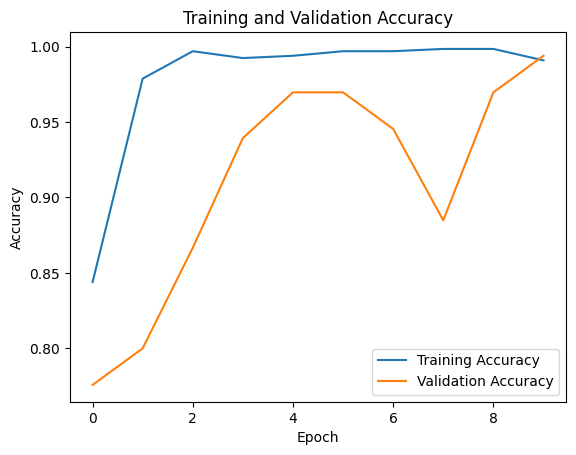

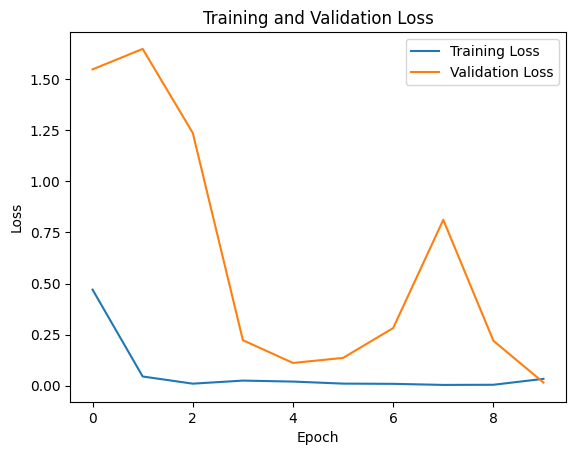

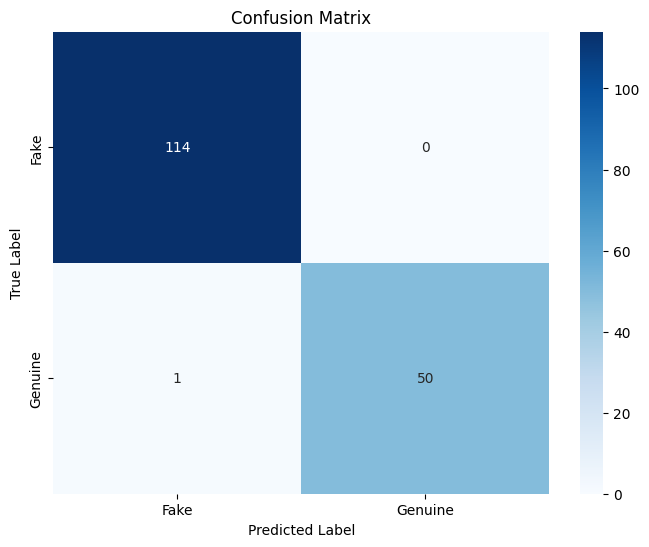

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


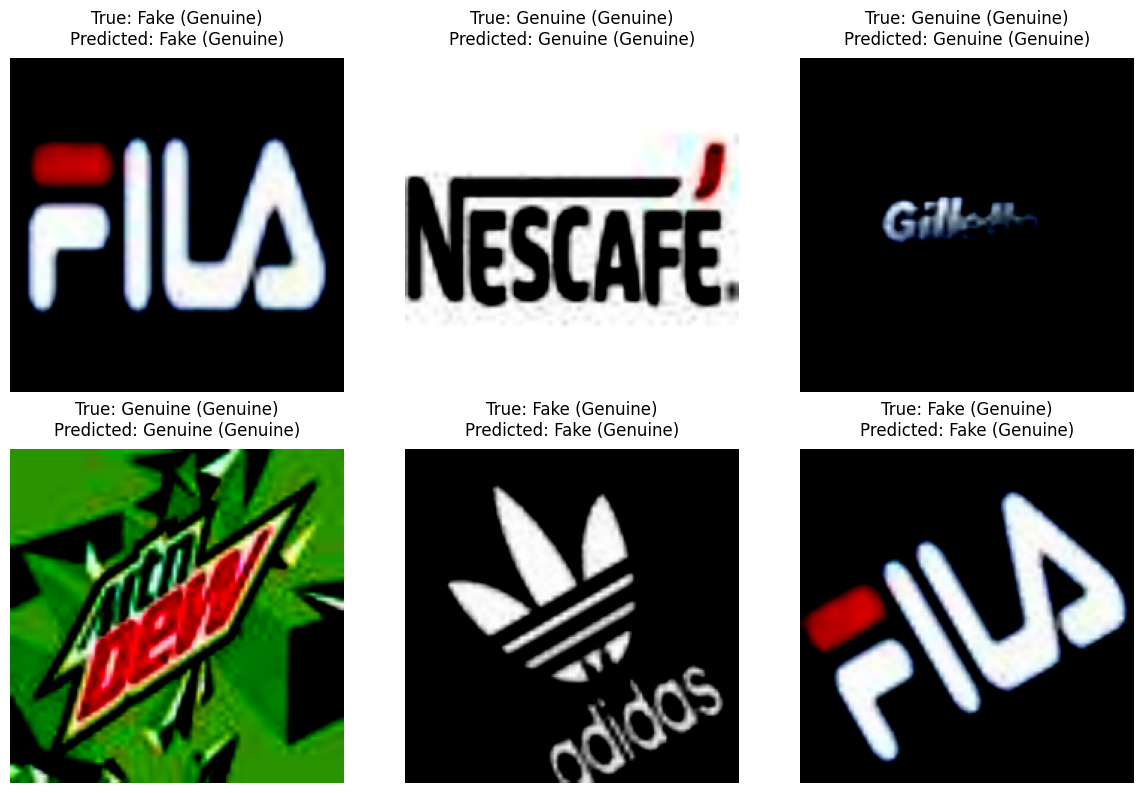

In [10]:
# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Show sample predictions with images
plt.figure(figsize=(12, 8))
for i in range(6):  # Show first 6 sample predictions
    plt.subplot(2, 3, i + 1)
    plt.imshow(test_images[i])
    true_label = label_encoder.inverse_transform([test_labels[i]])[0]
    pred_label = label_encoder.inverse_transform([y_pred[i]])[0]
    plt.title(f'True: {true_label} ({"Fake" if true_label == "0" else "Genuine"})\nPredicted: {pred_label} ({"Fake" if pred_label == "0" else "Genuine"})', pad=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


